## Behavioural Cloning for Self-driving Cars

A Deep Learning approach to Behavioural Cloning for Self-Driving Cars inspired from NVIDIA's recent effort documented in their paper here: http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

In [1]:
# Necessary imports
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### 1. Get the dataset

In [2]:
log_paths = [
    'data',
    'track2_1',   
    'track2_2'  
]

columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

def parse_logs(log_paths):
    '''
    Parse the driving logs, customise the image paths and concatenate all the logs in a single Pandas
    DataFrame
    :params log_paths: List of all the driving log paths
    :return: Pandas DataFrame
    '''
    frames = []
    for i, log_path in enumerate(log_paths):
        df = pd.read_csv(log_path + '/driving_log.csv')
        df.columns = columns
        if log_path == 'data':
            # corresponds to the Udacity sample
            for column in columns[:3]:
                df[column] = df[column].apply(lambda x: log_path+'/'+x.strip())
        else:
            for column in columns[:3]:
                df[column] = df[column].apply(lambda x: '/'.join(x.split('/')[-3:]))

        frames.append(df)
    return pd.concat(frames, ignore_index=True)
            
print('Parsing driving logs...')    
df = parse_logs(log_paths)
image = cv2.imread(df.loc[0]['center'].strip())
print('Parsing complete!')

Parsing driving logs...
Parsing complete!


### 2. Dataset summarisation, visualisation and cleanup

In [3]:
# Data set summarisation
print('Number of scene frames: {}'.format(len(df)))
print('Total frames (including the Left/Right prespectives): {}'.format(len(df) * 3))
print('Image shape: {}'.format(image.shape))

Number of scene frames: 17488
Total frames (including the Left/Right prespectives): 52464
Image shape: (160, 320, 3)


Avg # samples/bin: 342.9019607843137
Threshold 445


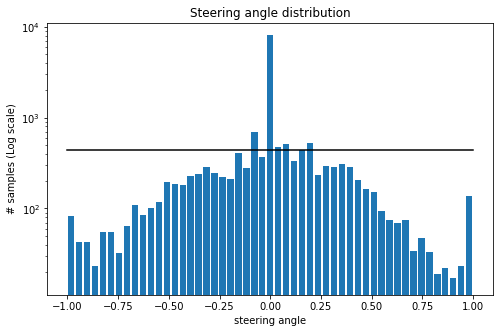

In [4]:
# Data set exploratory visualisation
# Visualising the steering angle distribution
hist, bins = np.histogram(df.steering, 51)
center = (bins[:-1] + bins[1:])/2

plt.figure(figsize=(8,5))
plt.bar(center, hist, align='center', width=(bins[0] - bins[1])*0.8, log=True)
plt.title('Steering angle distribution')
plt.ylabel('# samples (Log scale)')
plt.xlabel('steering angle')
avg_nb_samples = len(df['steering']) / 51
threshold = int(avg_nb_samples * 1.3)
plt.plot((df['steering'].min(), df['steering'].max()), (threshold, threshold), 'k-')

print('Avg # samples/bin: {}'.format(avg_nb_samples))
print('Threshold {}'.format(threshold))

[-362 -402 -402 -422 -390 -390 -413 -381 -336 -360 -343 -328 -251 -260 -262
 -220 -204 -157 -197 -221 -235  -37 -166  248  -74 7629   28   65 -113   -5
   80 -212 -150 -158 -139 -161 -237 -281 -292 -351 -370 -375 -371 -411 -398
 -412 -426 -423 -428 -422 -309]
23
25
26
27
30
Length of the dataset post cleanup: 9438


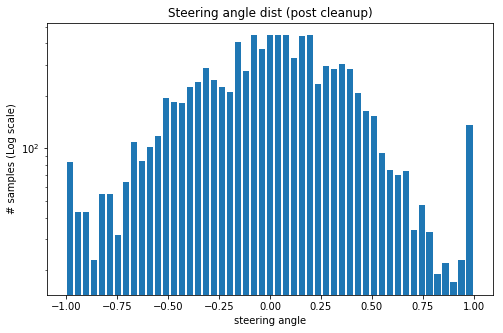

In [5]:
# Dataset cleanup
above_threshold = hist - threshold
print(above_threshold)
to_delete = []
for i in range(len(above_threshold)):
    if above_threshold[i] > 0:
        print(i)
        idxs = np.where(np.logical_and(df['steering'] >= bins[i], df['steering'] < bins[i+1]))[0]
        choices = idxs[np.random.choice(len(idxs), above_threshold[i], replace=False)]
        to_delete.extend(choices)

df = df.drop(to_delete).reset_index(drop=True)

print('Length of the dataset post cleanup: {}'.format(len(df)))

# Plot the distribution of the steering angles after the cleanup process
plt.figure(figsize=[8,5])
plt.hist(df['steering'], 51, rwidth=0.8, align='mid', histtype='bar', log=True)
plt.title('Steering angle dist (post cleanup)')
plt.ylabel('# samples (Log scale)')
plt.xlabel('steering angle')

center      data/IMG/center_2016_12_01_13_37_00_393.jpg
left          data/IMG/left_2016_12_01_13_37_00_393.jpg
right        data/IMG/right_2016_12_01_13_37_00_393.jpg
steering                                              0
throttle                                       0.985533
brake                                                 0
speed                                           30.1868
Name: 1070, dtype: object

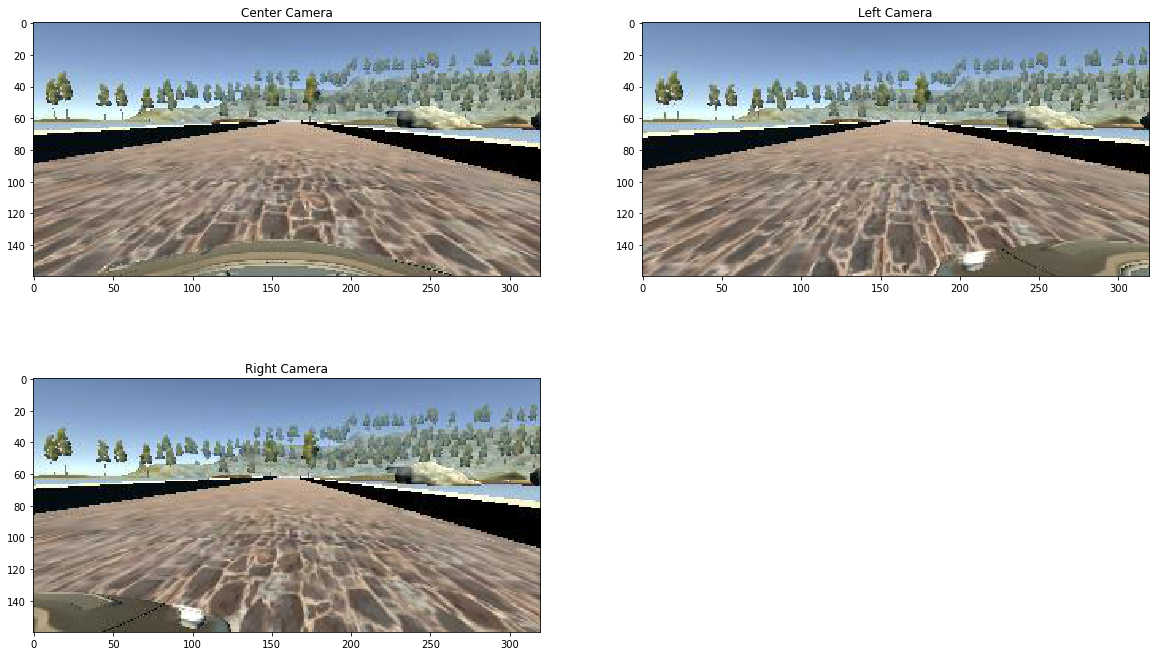

In [6]:
# Read in a sample and plot all three perspectives, i.e. 
# the center, left and right camera images
plt.subplots(figsize=(20, 12))
titles = ['Center', 'Left', 'Right']
for i in range(3):
    image = cv2.imread(df.loc[1070][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 2, i+1)
    plt.title(titles[i] + ' Camera')
    plt.imshow(image)

df.loc[1070]

### 3. Data augmentation

In [7]:
# 1. Brightness augmentation
def vary_brightness(image):
    '''
    Perform brightness augmentation, i.e. varied lighting conditions. This
    is achieved by converting the image from RGB -> HSV and randomly changing the
    Brightness (i.e. V) channel. Finally, the image is converted back to the RGB
    color space
    :param image: a RGB image represented a numpy ndarray
    :return: RGB image with varied brightness
    '''
    nimage = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    nimage = nimage.astype(np.uint32) # change from uint8 -> uint32 for varying the brightness
    
    random_bright = 0.25 + np.random.uniform()
    nimage[:,:,2] = nimage[:,:,2] * random_bright
    nimage[nimage > 255] = 255
    nimage = nimage.astype(np.uint8) # change back to uint8

    nimage = cv2.cvtColor(nimage, cv2.COLOR_HSV2RGB)
    return nimage

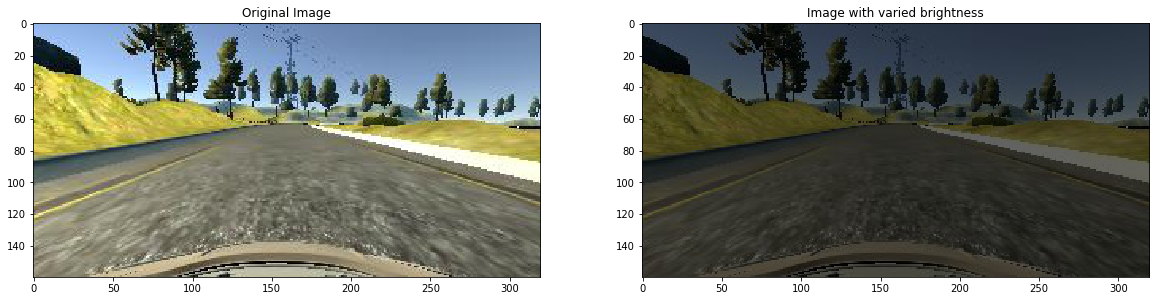

In [8]:
image = cv2.imread(df.loc[650][0].strip())
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.subplots(figsize=(20, 12))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(vary_brightness(image))
plt.title('Image with varied brightness')

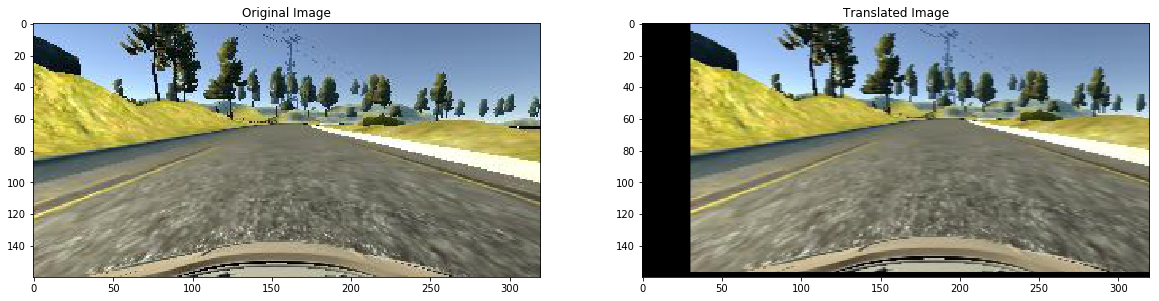

In [9]:
# 2. Translation- Horizontal and Vertical
def translation(image, steering, trans_range):
    '''
    Perform translation of the image along a horizontal and vertical axis
    :param image: Image, represented as a numpy ndarray
    :param steering: Steering angle, float32
    :trans_range: Horizontal axis translation range
    :return: Translated image, ndarray
    '''
    rows, cols, _ = image.shape
    tx = trans_range * np.random.uniform() - (trans_range / 2)
    ty = 10 * np.random.uniform() - 10 / 2
    steering = steering + tx / trans_range * 2 * 0.2 # Perform steering angle correction
    M = np.float32([[1, 0, tx], [0, 1, ty]]) # Transformation matrix
    dst = cv2.warpAffine(image, M, (cols, rows))
    return dst, steering

plt.subplots(figsize=(20,12))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(translation(image, 0, 80)[0])
plt.title('Translated Image')

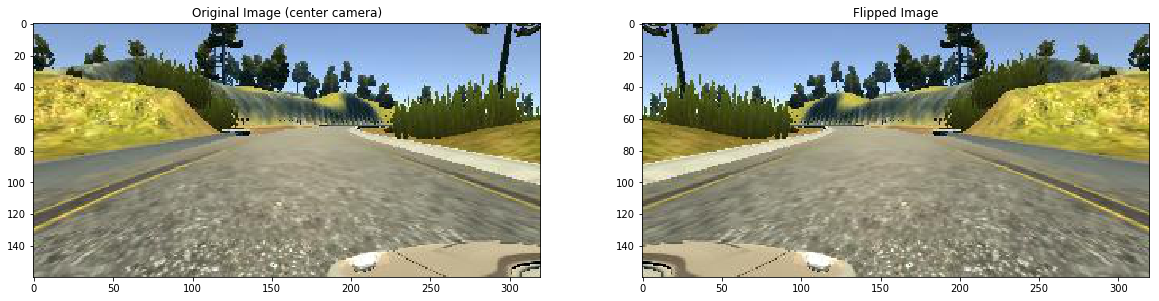

In [10]:
# 3. Flipping
def flip(image, steering):
    '''
    Flips the input image and steering angle
    :param image: Image, represented as a numpy ndarray
    :param steering: Steering angle
    :return: Flipped image
    '''
    return np.fliplr(image), -steering

image = cv2.imread(df.iloc[200]['left'].strip())
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.subplots(figsize=(20,12))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image (center camera)')
plt.subplot(122)
plt.imshow(flip(image, 0)[0])
plt.title('Flipped Image')

### 4. Generator setup

In [11]:
# Set up the generator to be used with keras' fit_generator()

from sklearn.utils import shuffle
import math

def parse_sample(sample, perspective=0, steering_correction=0.25):
    '''
    Function that:
    1. Loads in the image from its corresponding path,
    2. Converts from BGR -> RGB color space, and,
    3. Applies the necessary steering angle correction based on the chosen perspective
    :pd.Series sample: Sample of a scene frame from the driving logs
    :int persective: Camera perspective (center/left/right)
    :int steering_correction: Steering angle correction factor
    :return (ndarray, int): Image, Steering angle
    '''
    image_path = sample[perspective].strip()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    steering = sample['steering']
                       
    if perspective == 1: # left
        steering += steering_correction
    elif perspective == 2: # right
        steering -= steering_correction
                       
    return image, steering
   
def augment_image(image, steering):
    '''
    Performs image augmentation by performing brightness augmentation or translation or
    a combination of both. The augmentation method is sampled at random from the above set
    with uniform probab (i.e 33%)
    :int image: Image
    :int steering: Steering angle
    :return (ndarray, int): Image, Steering angle
    '''
    trans_range = 80
    nsteering = steering
    aug_type = np.random.randint(3)
    
    if aug_type == 0: # Vary lighting conditions
        nimage = vary_brightness(image)
    elif aug_type == 1: # Translation
        nimage, nsteering = translation(image, steering, trans_range=trans_range)
    elif aug_type == 2: # Translation + lighting conditions
        nimage = vary_brightness(image)
        nimage, nsteering = translation(nimage, nsteering, trans_range=trans_range)
    
    return nimage, nsteering

def get_generator_true_batch_size(desired_batch_size, nb_perspectives, nb_augs_per_image):
    transformations_per_image = 2 + nb_augs_per_image # 2 represents the original + flipped image
    images_per_sample = nb_perspectives * transformations_per_image
    return math.ceil(desired_batch_size / images_per_sample), images_per_sample

def generator(samples, batch_size, nb_perspectives=1, perform_aug=False, nb_augs_per_image=1):
    '''
    Python generator that generates on-demand batches of images from the driving log samples
    :pd.DataFrame samples: Driving log subset
    :int batch_size: Desired batch size
    :int nb_perspectives: Number of perspectives, i.e. camera images to use for each scene frame
    :bool perform_aug: Boolean flag for performing the augmentation process
    :int nb_augs_per_image: Number of additional images to generate for each image
    :return: Generator instance
    '''
    while True:
        samples = shuffle(samples)

        for offset in range(0, len(samples), batch_size):
            batch = samples[offset: offset+batch_size]
            
            images = []
            angles = []
            
            for _, sample in batch.iterrows():
                for perspective in range(nb_perspectives):
                    # Original
                    image, steering = parse_sample(sample,
                                                perspective=perspective, steering_correction=0.175)
                       
                    # Flip
                    fimage, fsteering = flip(image, steering)
                    
                    images.extend([image, fimage])
                    angles.extend([steering, fsteering])
                    
                    if perform_aug:
                        for _ in range(nb_augs_per_image):
                            should_aug_flipped = np.random.randint(2)
                            
                            if should_aug_flipped:
                                # Augment Flipped version
                                aug_image, aug_steering = augment_image(fimage, fsteering)
                            else:
                                # Augment Original version
                                aug_image, aug_steering = augment_image(image, steering)

                            images.append(aug_image)
                            angles.append(aug_steering)
            
            X_train, y_train = np.array(images), np.array(angles)
            yield shuffle(X_train, y_train)

def get_generator_instance(samples, batch_size=32, use_all_perspectives=False, perform_aug=False, nb_augs_per_image=1):
    if use_all_perspectives:
        nb_perspectives = 3
    else:
        nb_perspectives = 1
    
    gen_batch_size, images_per_sample = get_generator_true_batch_size(batch_size, nb_perspectives, nb_augs_per_image)
    nb_batches = math.ceil(len(samples) / gen_batch_size)
    
    print()
    print('*****Generator Summary*****')
    print('len(samples): {}'.format(len(samples)))
    print('Generator True batch size: {} vs Desired batch size: {}'.format(gen_batch_size, batch_size))
    print('Images per sample: {}'.format(images_per_sample))
    print('# batches in samples: {}'.format(nb_batches))
    print('Total # images: {}'.format(len(samples) * images_per_sample))
    print()
    gen = generator(samples, gen_batch_size, nb_perspectives, perform_aug, nb_augs_per_image)
    
    return gen, nb_batches

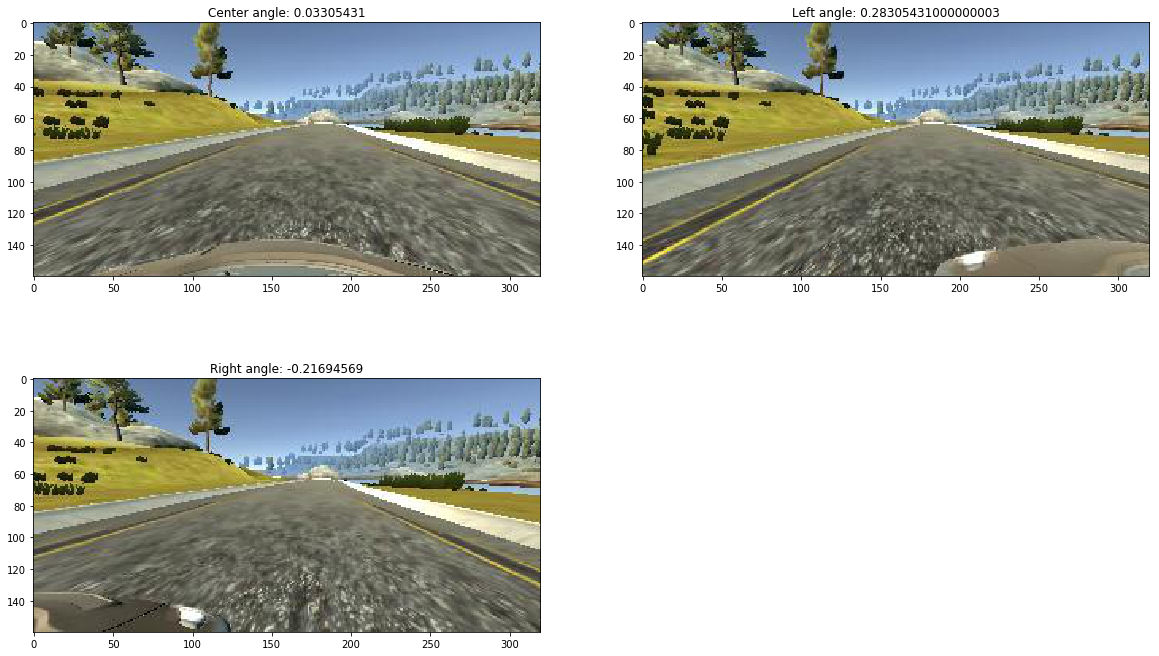

In [12]:
# Testing the parse_sample function
sample = df.loc[600]
plt.subplots(figsize=(20, 12))
plt.subplot(221)
sc = parse_sample(sample, 0)
plt.imshow(sc[0])
plt.title('Center angle: {}'.format(sc[1]))
assert(sample['steering'] == sc[1])

plt.subplot(222)
sl = parse_sample(sample, 1)
plt.imshow(sl[0])
plt.title('Left angle: {}'.format(sl[1]))

plt.subplot(223)
sr = parse_sample(sample, 2)
plt.imshow(sr[0])
plt.title('Right angle: {}'.format(sr[1]))

In [13]:
# Testing the get_generator_instance function
gen, _ = get_generator_instance(df, use_all_perspectives=True, perform_aug=True)
imgs, angles = next(gen)


*****Generator Summary*****
len(samples): 9438
Generator True batch size: 4 vs Desired batch size: 32
Images per sample: 9
# batches in samples: 2360
Total # images: 84942



In [14]:
# Sanity check
assert(len(imgs) == len(angles))
print(len(imgs))

36


### 5. Define and implement Model Architecture

In [15]:
from keras.models import Sequential, load_model
from keras.layers import Input, Flatten, Cropping2D, Lambda, Conv2D, Dense, Dropout, ELU
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
from datetime import datetime

models_save_path = './models/'
INPUT_SHAPE = (160, 320, 3)
MODEL_CHOICE = 'nvidia'

def resize_images(images):
    from keras.backend import tf as ktf
    return ktf.image.resize_images(images, (128, 128))

if MODEL_CHOICE == 'nvidia':
    # Define and implement the model architecture
    model = Sequential()
    model.add(Cropping2D(cropping=((70, 20),(0, 0)), input_shape=INPUT_SHAPE, name='Crop'))
    model.add(Lambda(resize_images, name='Lambda1'))
    model.add(Lambda(lambda x: (x / 255.0 - 0.5) * 2, name='Lambda2'))

    # 1x1 convolution layer to determine best color model
    model.add(Conv2D(3, 1, strides=1, padding="same", kernel_initializer='he_normal', name='C1'))
    
    model.add(Conv2D(24, kernel_size=5, strides=2, kernel_initializer='he_normal', name='C2'))
    model.add(ELU(alpha=0.1, name='C2_ELU'))

    model.add(Conv2D(36, kernel_size=5, strides=2, kernel_initializer='he_normal', name='C3'))
    model.add(ELU(alpha=0.1, name='C3_ELU'))

    model.add(Conv2D(48, kernel_size=5, strides=2, kernel_initializer='he_normal', name='C4'))
    model.add(ELU(alpha=0.1, name='C4_ELU'))
    model.add(Dropout(0.3, name='C4_DROP'))

    model.add(Conv2D(64, kernel_size=3, strides=1, kernel_initializer='he_normal', name='C5'))
    model.add(ELU(alpha=0.1, name='C5_ELU'))
    model.add(Dropout(0.3, name='C5_DROP'))

    model.add(Conv2D(64, kernel_size=3, strides=1, kernel_initializer='he_normal', name='C6'))
    model.add(ELU(alpha=0.1, name='C6_ELU'))
    model.add(Flatten(name='Flatten'))

    model.add(Dense(100, kernel_initializer='he_normal', name='D7'))
    model.add(ELU(alpha=0.1, name='D7_ELU'))
    model.add(Dropout(0.3, name='D7_DROP'))

    model.add(Dense(50, kernel_initializer='he_normal', name='D8'))
    model.add(ELU(alpha=0.1, name='D8_ELU'))
    model.add(Dropout(0.3, name='D8_DROP'))

    model.add(Dense(10, kernel_initializer='he_normal', name='D9'))
    model.add(ELU(alpha=0.1, name='D9_ELU'))

    model.add(Dense(1, name='D10'))
        
    # Setup the training and evaluation pipeline
    optimiser = Adam(lr=0.0005)
    model.compile(loss='mse', optimizer=optimiser)
    
else:
    # Load the saved model and resume training
    try:
        model = load_model(MODEL_CHOICE)
        print('Model {} loaded!'.format(MODEL_CHOICE))
    except Exception as e:
        print('Failed to load the model: {} with exception: {}'.format(MODEL_CHOICE, e))

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Crop (Cropping2D)            (None, 70, 320, 3)        0         
_________________________________________________________________
Lambda1 (Lambda)             (None, 128, 128, 3)       0         
_________________________________________________________________
Lambda2 (Lambda)             (None, 128, 128, 3)       0         
_________________________________________________________________
C1 (Conv2D)                  (None, 128, 128, 3)       12        
_________________________________________________________________
C2 (Conv2D)                  (None, 62, 62, 24)        1824      
_________________________________________________________________
C2_ELU (ELU)                 (None, 62, 62, 24)        0         
_________________________________________________________________
C3 (Conv2D)                  (None, 29, 29, 36)        21636     
__________

### 6. Train and Evaluate the model

In [ ]:
### Run the training pipeline

# Split the data set into training and validation sets with a 0.2 split
data_train, data_valid = train_test_split(df, test_size=0.2)

# Get the train and validation generator instances
generator_train, steps_train = get_generator_instance(data_train, batch_size=32,
                                         use_all_perspectives=True, perform_aug=True)

generator_valid, steps_valid = get_generator_instance(data_valid, batch_size=32)

# Get the callbacks for early stopping and creating model checkpoints
early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=3)
model_checkpoint = ModelCheckpoint(filepath=models_save_path+'model-{val_loss:.4f}.h5', monitor='val_loss', verbose=0)

print('*****Training*****')
history = model.fit_generator(
    generator=generator_train,
    steps_per_epoch=steps_train,
    validation_data=generator_valid,
    validation_steps=steps_valid,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint])

In [ ]:
print('*****Plotting Learning curves*****')

# Plot the learning curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Mean Squared Error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

print('*****Saving model summary*****')
# Save model summary
timestamp = datetime.now().strftime("%d-%h-%m-%s")
with open(models_save_path+'summary-{}.txt'.format(timestamp), mode='w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))